In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import plot_importance

import shap

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


In [3]:
data.shape

(1338, 7)

## Exploratory Data Analysis

In [4]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

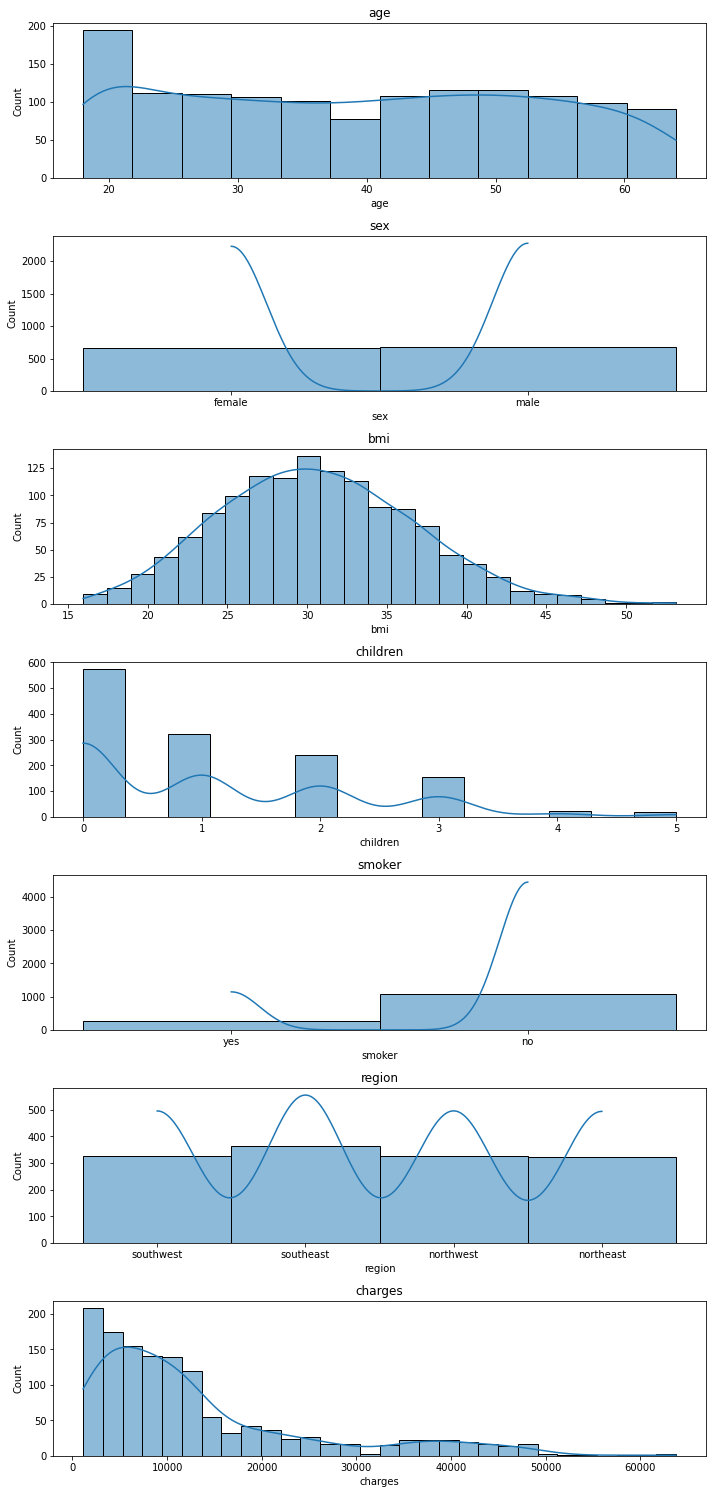

In [5]:
plt.figure(figsize=(10,50))
for i in range(len(data.columns)):
    plt.subplot(17, 1, i + 1)
    sns.histplot(data[data.columns[i]], kde = True)
    plt.title(data.columns[i])
plt.tight_layout();

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


In [8]:
data.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

## One Hot Encoding

In [9]:
data_encoded = pd.get_dummies(data,columns = ['smoker','region','sex'])
data_encoded.head()

,age,bmi,children,charges,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,sex_female,sex_male
0,19,27.90,0,16884.92,0,1,0,0,0,1,1,0
1,18,33.77,1,1725.55,1,0,0,0,1,0,0,1
2,28,33.00,3,4449.46,1,0,0,0,1,0,0,1
3,33,22.70,0,21984.47,1,0,0,1,0,0,0,1
4,32,28.88,0,3866.86,1,0,0,1,0,0,0,1


In [10]:
#dropping to remove multicollinearity
data_encoded.drop(['smoker_no','region_northeast','sex_female'],axis=1,inplace=True)

In [11]:
data_encoded.head(10)

,age,bmi,children,charges,smoker_yes,region_northwest,region_southeast,region_southwest,sex_male
0,19,27.90,0,16884.92,1,0,0,1,0
1,18,33.77,1,1725.55,0,0,1,0,1
2,28,33.00,3,4449.46,0,0,1,0,1
3,33,22.70,0,21984.47,0,1,0,0,1
4,32,28.88,0,3866.86,0,1,0,0,1
5,31,25.74,0,3756.62,0,0,1,0,0
6,46,33.44,1,8240.59,0,0,1,0,0
7,37,27.74,3,7281.51,0,1,0,0,0
8,37,29.83,2,6406.41,0,0,0,0,1
9,60,25.84,0,28923.14,0,1,0,0,0


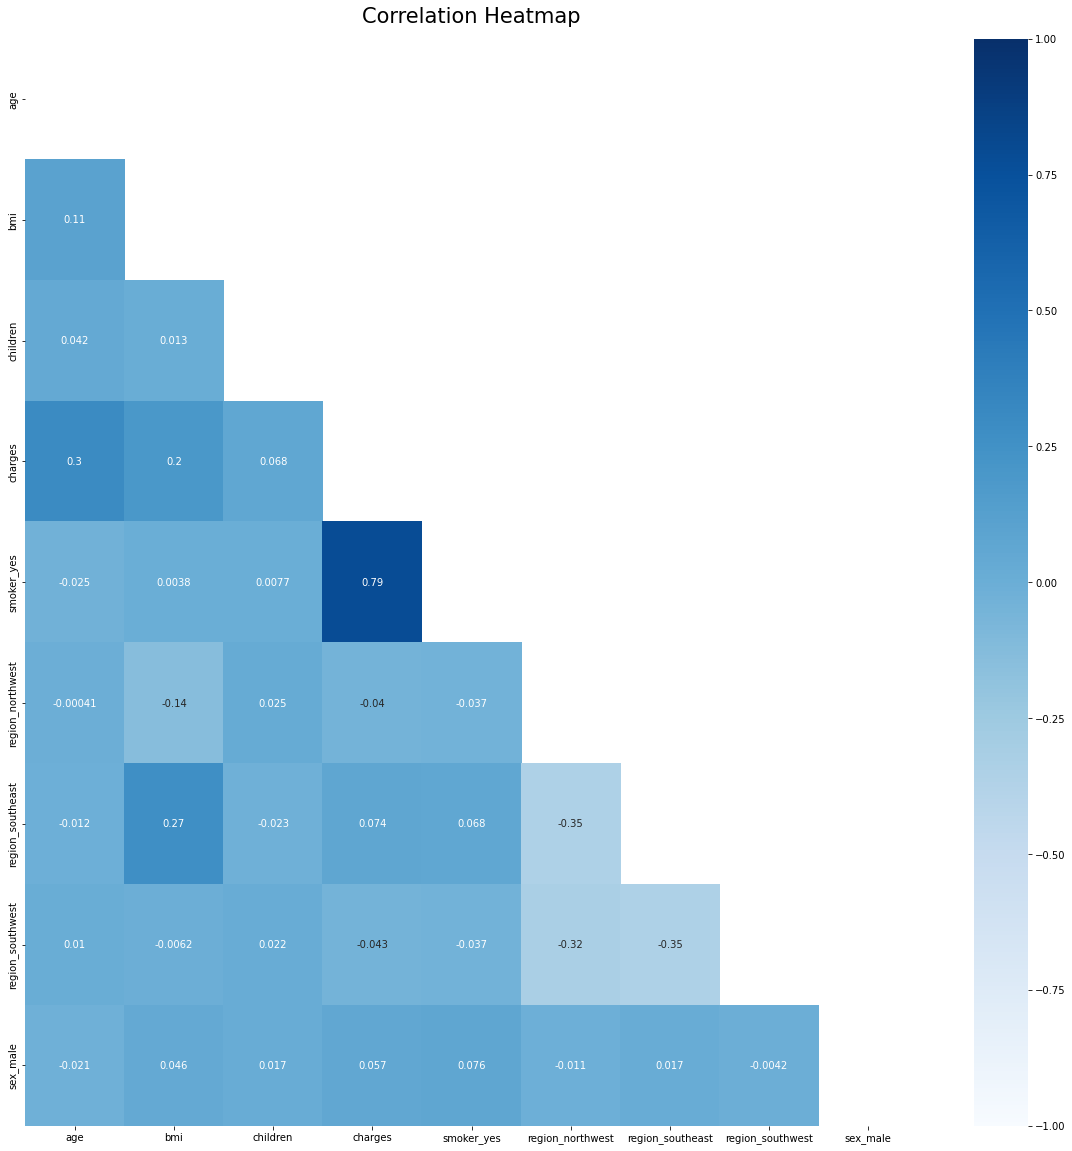

In [12]:
plt.subplots(figsize=(20,20))

mask = np.triu(np.ones_like(data_encoded.corr()))
heatmap = sns.heatmap(data_encoded.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':21}, pad=16);

In [13]:
X = data_encoded.drop('charges',axis=1)
y = data_encoded.charges

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y ,random_state=104, test_size=0.2, shuffle=True)

In [15]:
X_train.shape, X_test.shape, y_train.shape,y_test.shape

((1070, 8), (268, 8), (1070,), (268,))

In [16]:
X_train.head()

,age,bmi,children,smoker_yes,region_northwest,region_southeast,region_southwest,sex_male
516,20,35.31,1,0,0,1,0,1
622,49,21.30,1,0,0,0,1,0
1168,32,35.20,2,0,0,0,1,1
1097,22,33.77,0,0,0,1,0,1
363,21,26.40,1,0,0,0,1,0


In [17]:
model = LinearRegression()

model.fit(X_train, y_train)

print('model intercept :', model.intercept_)
print('model coefficients : ', model.coef_)
print('Model score : ', model.score(X, y))

model intercept : -11757.71808512792
model coefficients :  [  257.97804775   319.71492518   414.1291951  24226.52711715
  -213.37441902  -617.2599799   -530.2491781     70.02242358]
Model score :  0.7503762510008057


In [18]:
coeff_parameter = pd.DataFrame(model.coef_,X_train.columns,columns=['Coefficient'])
coeff_parameter

,Coefficient
age,257.98
bmi,319.71
children,414.13
smoker_yes,24226.53
region_northwest,-213.37
region_southeast,-617.26
region_southwest,-530.25
sex_male,70.02


Text(0, 0.5, 'Predicted Data')

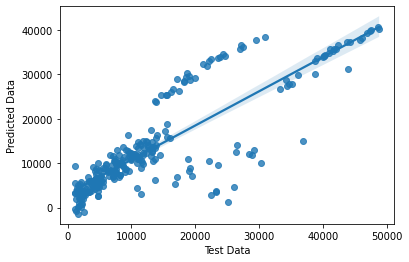

In [19]:
predictions = model.predict(X_test)
sns.regplot(y_test,predictions)
plt.xlabel('Test Data')
plt.ylabel('Predicted Data')

In [20]:
mse = mean_squared_error(y_test, predictions)
print("RMSE: %.2f" % (mse**(1/2.0)))

y_test2 = pd.DataFrame(y_test).reset_index(drop=True)
y_pred2 = pd.DataFrame(predictions,columns = ['pred'])
MAPE = ((y_pred2.pred - y_test2.charges)/y_test2.charges).mean()
print("MAPE: ",round(MAPE,2))

RMSE: 6333.25
MAPE:  0.19


In [21]:
import statsmodels.api as sm
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     413.7
Date:                Mon, 19 Dec 2022   Prob (F-statistic):          7.36e-320
Time:                        23:03:55   Log-Likelihood:                -10822.
No. Observations:                1070   AIC:                         2.166e+04
Df Residuals:                    1061   BIC:                         2.171e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.176e+04   1088.439  

# Polynomial Regression

In [22]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
poly_train = poly.fit_transform(X_train)
poly_test = poly.fit_transform(X_test)


rfe_selector = RFE(estimator=LinearRegression(),n_features_to_select = 20, step = 1)
reduced_train =  rfe_selector.fit_transform(poly_train, y_train)
reduced_test = pd.DataFrame(poly_test)[pd.DataFrame(poly_test).columns[rfe_selector.fit(poly_train, y_train).support_]]


In [23]:
reduced_model = LinearRegression()

reduced_model.fit(reduced_train, y_train)

print('model intercept :', reduced_model.intercept_)
print('model coefficients : ', reduced_model.coef_)
print('RMSE : ', (mean_squared_error(reduced_model.predict(reduced_test),y_test))**(0.5))
print('MAPE : ', ((reduced_model.predict(reduced_test) - y_test)/y_test).mean())
print('R2 score : ', r2_score(reduced_model.predict(reduced_test), y_test))

model intercept : -2335.4161769766397
model coefficients :  [   270.20205825    775.80740913 -10244.57015975   -566.33303613
   -430.21938243   -369.0395656    1471.45492539   -419.96535187
    444.38324319   -376.63798404   -415.10644924 -10244.57015975
   -334.89072585   1318.89728691   -506.21838851   -566.33303613
    433.82942927   -430.21938243   -369.0395656     254.03863768]
RMSE :  5197.502381157
MAPE :  0.12489187498879484
R2 score :  0.7905925923346196


In [24]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)
models

 98%|█████████▊| 41/42 [01:05<00:01,  1.92s/it]

[23:05:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 42/42 [01:05<00:00,  1.56s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
XGBRegressor,0.82,0.83,4961.68,0.13
GradientBoostingRegressor,0.82,0.83,4969.44,0.28
HistGradientBoostingRegressor,0.80,0.81,5235.52,8.87
RandomForestRegressor,0.80,0.81,5254.84,0.38
LGBMRegressor,0.80,0.81,5277.25,0.09
BaggingRegressor,0.80,0.80,5358.94,0.10
ExtraTreesRegressor,0.79,0.80,5403.84,0.70
AdaBoostRegressor,0.79,0.80,5426.44,0.10
KNeighborsRegressor,0.76,0.76,5850.02,0.02


## XGBoost

In [25]:
#xgbr = xgb.XGBRegressor(objective='reg:squarederror')
xgbr = xgb.XGBRegressor(objective='reg:squarederror')
xgbr.fit(X_train, y_train)
 
y_pred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("RMSE: %.2f" % (mse**(1/2.0)))

y_test2 = pd.DataFrame(y_test).reset_index(drop=True)
y_pred2 = pd.DataFrame(y_pred,columns = ['pred'])
MAPE = ((y_pred2.pred - y_test2.charges)/y_test2.charges).mean()
print("MAPE: ",round(MAPE,2))

from sklearn.metrics import r2_score
r2 = r2_score(xgbr.predict(X_train),y_train)
print('R-squared: ',round(r2,2))

RMSE: 4961.68
MAPE:  0.17
R-squared:  0.89


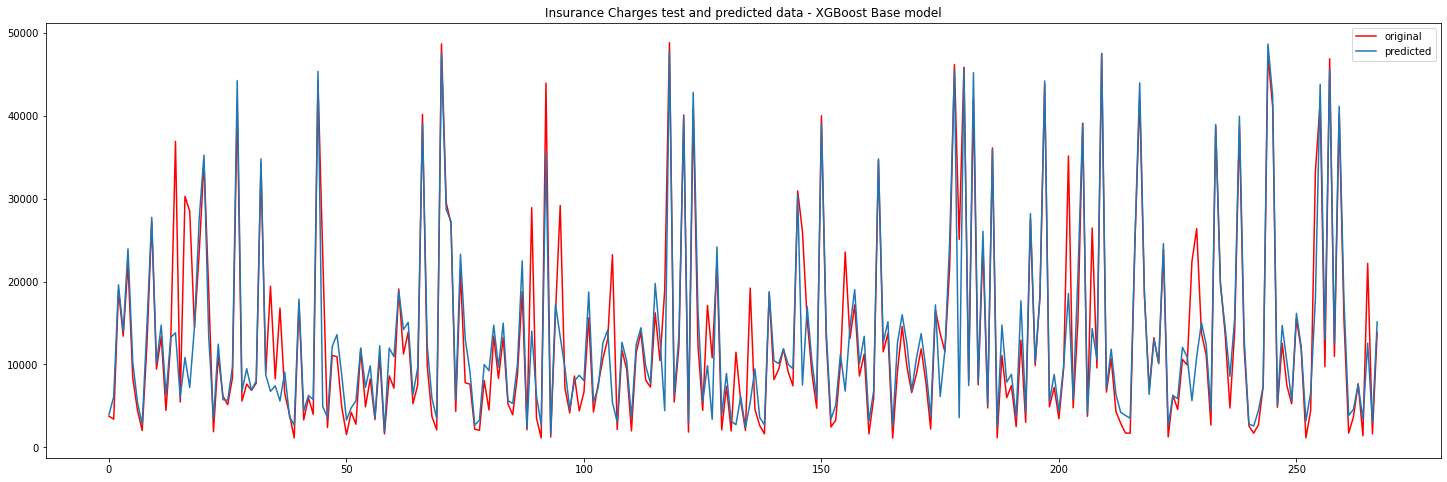

In [26]:
x_ax = range(len(y_test))
plt.figure(figsize = (25,8))
plt.plot(x_ax, y_test, label="original", color = 'red')
plt.plot(x_ax, y_pred, label="predicted")
plt.title('''Insurance Charges test and predicted data - XGBoost Base model''')
plt.legend()
plt.show()

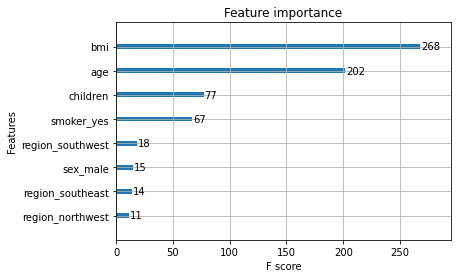

In [27]:
plot_importance(xgbr, max_num_features=8) 
plt.show()

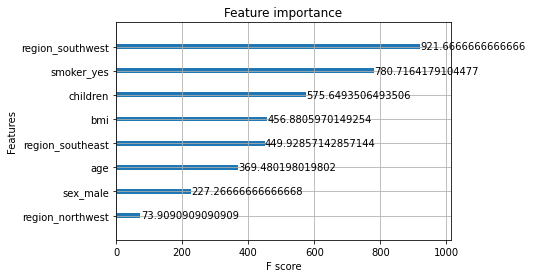

In [28]:
plot_importance(xgbr, max_num_features=8, importance_type = "cover") 
plt.show()

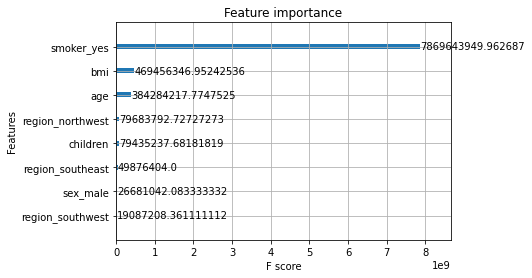

In [29]:
plot_importance(xgbr, max_num_features=8, importance_type = "gain") 
plt.show()

## Hyperparameter tuning

## GridSearch

In [30]:
# params = { 'max_depth': [3,6,10],
#            'learning_rate': [0.01, 0.05, 0.1],
#            'n_estimators': [100, 500, 1000],
#            'colsample_bytree': [0.3, 0.7]}
# xgbr = xgb.XGBRegressor(seed = 20)
# clf = GridSearchCV(estimator=xgbr, 
#                    param_grid=params,
#                    scoring='neg_mean_squared_error', 
#                    verbose=1)
# clf.fit(X_train, y_train)
# print("Best parameters:", clf.best_params_)
# print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

In [47]:
#using best model parameters from grid search 
xgbr = xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree = 0.7,learning_rate= 0.01, max_depth = 3, n_estimators = 1000)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("RMSE: %.2f" % (mse**(1/2.0)))

y_test2 = pd.DataFrame(y_test).reset_index(drop=True)
y_pred2 = pd.DataFrame(y_pred,columns = ['pred'])
MAPE = ((y_pred2.pred - y_test2.charges)/y_test2.charges).mean()
print("MAPE: ",MAPE)

from sklearn.metrics import r2_score
r2 = r2_score(xgbr.predict(X_train),y_train)
print('R-squared: ',r2)

RMSE: 5034.57
MAPE:  0.1912404496875777
R-squared:  0.8874753283648437


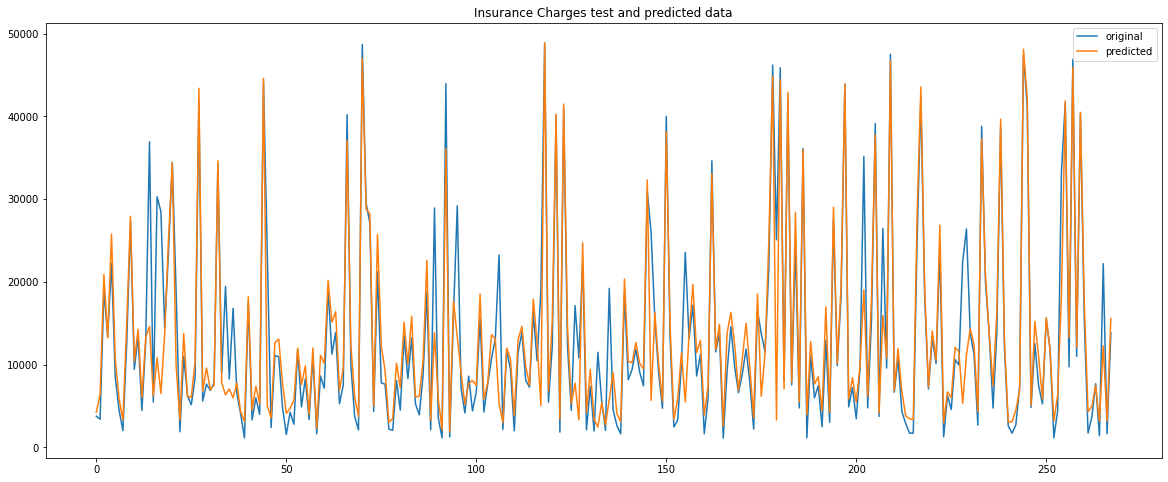

In [32]:
x_ax = range(len(y_test))
plt.figure(figsize = (20,8))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Insurance Charges test and predicted data")
plt.legend()
plt.show()

## Randomized Search

In [33]:
# params = { 'max_depth': [3, 5, 6, 10, 15, 20],
#            'learning_rate': [0.01, 0.1, 0.2, 0.3],
#            'subsample': np.arange(0.5, 1.0, 0.1),
#            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
#            'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
#            'n_estimators': [100, 500, 1000]}
# xgbr = xgb.XGBRegressor(seed = 20)
# clf = RandomizedSearchCV(estimator=xgbr,
#                          param_distributions=params,
#                          scoring='neg_mean_squared_error',
#                          n_iter=25,
#                          verbose=1)
# clf.fit(X_train, y_train)
# print("Best parameters:", clf.best_params_)
# print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

In [34]:
#using best model parameters from randomized search - OVERFITTING CASE
xgbr = xgb.XGBRegressor(objective='reg:squarederror',subsample = 0.8999999999999999, 
                        n_estimators =  100, max_depth =  3, learning_rate =  0.3, colsample_bytree = 0.7, colsample_bylevel = 0.7)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("RMSE: %.2f" % (mse**(1/2.0)))

y_test2 = pd.DataFrame(y_test).reset_index(drop=True)
y_pred2 = pd.DataFrame(y_pred,columns = ['pred'])
MAPE = ((y_pred2.pred - y_test2.charges)/y_test2.charges).mean()
print("MAPE: ",MAPE)

from sklearn.metrics import r2_score
r2 = r2_score(xgbr.predict(X_train),y_train)
print('R-squared: ',r2)

RMSE: 5193.00
MAPE:  0.13430838776780724
R-squared:  0.9141399244262081


# Decision Tree

In [35]:
# reg = DecisionTreeRegressor(random_state=0)
# parameters = {'min_samples_split':[i for i in range(2,15)], 'max_depth':[i for i in range(10,25)]+[None],'min_samples_leaf':[i for i in range(1,25)],'min_impurity_decrease':[0.001*i for i in range(0,4)],'criterion':["squared_error"]}
# clf22 = GridSearchCV(reg,parameters)
# clf22.fit(X_train,y_train)
# clf22.best_estimator_

In [36]:
#using best model parameters 
regr_1 = DecisionTreeRegressor(max_depth=10, min_samples_leaf=21, random_state=0)
regr_1.fit(X_train, y_train)
y_pred = regr_1.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print("RMSE: %.2f" % (mse**(1/2.0)))

y_test2 = pd.DataFrame(y_test).reset_index(drop=True)
y_pred2 = pd.DataFrame(y_pred,columns = ['pred'])
MAPE = ((y_pred2.pred - y_test2.charges)/y_test2.charges).mean()
print("MAPE: ",MAPE)

from sklearn.metrics import r2_score
r2 = r2_score(regr_1.predict(X_train),y_train)
print('R-squared: ',r2)

RMSE: 5284.07
MAPE:  0.14587909073622138
R-squared:  0.868143902703388


# Random Forest

In [37]:
#takes time to run for this grid search - best parameters are in the next cell
# rf = RandomForestRegressor(random_state=0)
# parameters = {'n_estimators':[50,100,150,200],'min_samples_leaf':[i for i in range(2,15)],'max_depth':[i for i in range(1,10)]+[None],'min_impurity_decrease':[0.001*i for i in range(0,5)]}
# rf22 = GridSearchCV(rf,parameters)
# rf22.fit(X_train,y_train)
# rf22.best_estimator_


In [40]:
#regr_2 = RandomForestRegressor() # based model
regr_2 = RandomForestRegressor(max_depth=5, min_samples_leaf=9, random_state=0) #best model
regr_2.fit(X_train, y_train)
y_pred = regr_2.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("RMSE: %.2f" % (mse**(1/2.0)))

y_test2 = pd.DataFrame(y_test).reset_index(drop=True)
y_pred2 = pd.DataFrame(y_pred,columns = ['pred'])
MAPE = ((y_pred2.pred - y_test2.charges)/y_test2.charges).mean()
print("MAPE: ",round(MAPE,2))

from sklearn.metrics import r2_score
r2 = r2_score(regr_2.predict(X_train),y_train)
print('R-squared: ',round(r2,2))

#print(regr_2.score(X_test, y_test))

RMSE: 4994.38
MAPE:  0.18
R-squared:  0.87


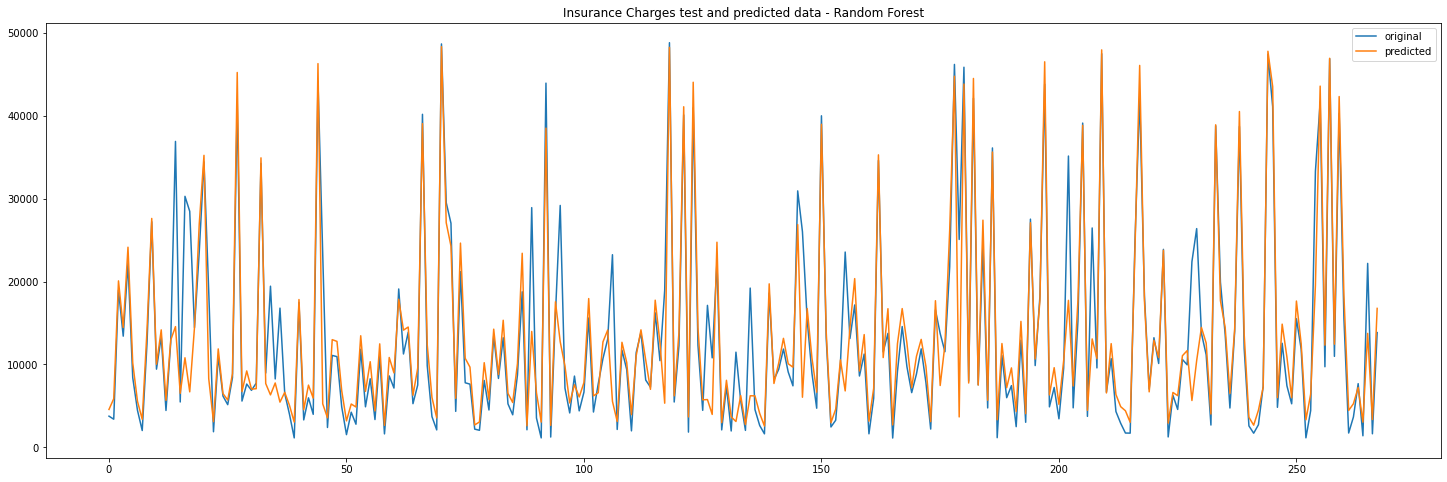

In [41]:
x_ax = range(len(y_test))
plt.figure(figsize = (25,8))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title('''Insurance Charges test and predicted data - Random Forest''')
plt.legend()
plt.show()

# SHAP

In [42]:
shap.initjs()

In [43]:
explainer = shap.TreeExplainer(xgbr)
shap_values = explainer.shap_values(X_train)

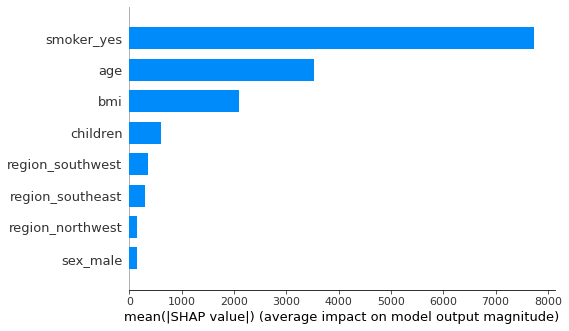

In [44]:
shap.summary_plot(shap_values, X_train, plot_type="bar")   #gives a basic barplot of mean SHAP values

In [45]:
shap.force_plot(explainer.expected_value, shap_values, X_train) #idk what this does exactly, should remove

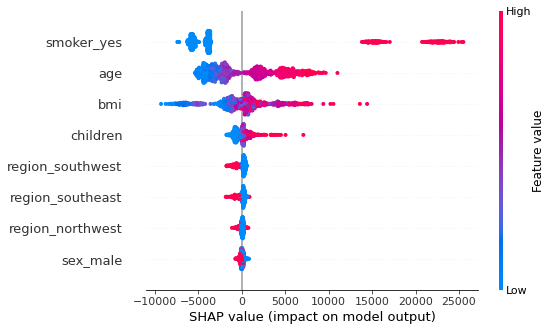

In [46]:
shap.summary_plot(shap_values, X_train)   #gives a better breakdown of the above features